In [247]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus.reader import PlaintextCorpusReader
import string
import re # regular expression library
import sys
import pandas as pd
import json
import os
import io
from pprint import pprint
from contextlib import redirect_stdout
# import matplotlib
# matplotlib.use('agg')

import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in(username='milessb', api_key='K0dYRqMXAI40uEGj7Tp5')

import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
from datetime import datetime
import math
import matplotlib.dates as mdates
import gensim
from gensim import corpora, models, similarities
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures

import scattertext as st
import spacy.en
from scattertext import CorpusFromPandas, produce_scattertext_explorer

In [2]:
json_file_path = '/Users/geomando/Dropbox/github/SeattleSeismicCulture/SeattleTimesQuakeArticles/json/'
txt_file_path = '/Users/geomando/Dropbox/github/SeattleSeismicCulture/SeattleTimesQuakeArticles/txt/'

In [3]:
filenames_json = [f for f in os.listdir(json_file_path) if f.endswith('.json')]
filenames_json[:10]

['1985-01-06_44StatesWarnedOfQuakePeril.json',
 '1985-01-12_PoulsboAreaRattledBySmallQuake.json',
 '1985-01-13_SimulatedQuakeMayShakeUpBridge-DesignChanges.json',
 '1985-01-24_QuakePredictorsAimToFoolMotherNature-ScientistsInAleutiansTrackEarthSEveryMove.json',
 '1985-02-13_QuakeRattlesPartsOfColumbiaBasin.json',
 '1985-02-14_StrongQuakeHitsRemoteAlaskaArea.json',
 '1985-03-04_124Die2000HurtInChileanQuake.json',
 '1985-03-06_Quake-HitChileGetsWarningOfTyphoid.json',
 '1985-03-08_After-Shock-SantiagoS`OldTownBecomesATentCityForQuakeSurvivors.json',
 '1985-03-14_StrongEarthquakeRattlesWesternOregonNoInjuriesReported.json']

Read in JSON files

In [4]:
articles_json = []
for file in filenames_json:
    with open(json_file_path + file, 'r') as f:
         articles_json.append(json.load(f))

Create txt files from JSON file field 'text' (raw article text)

In [5]:
# for json in articles_json:
#     with open(txt_file_path + json['filename'][:-5] + '.txt', 'w') as f:
#         print(json['text'], file=f)

In [6]:
nltk_corpus = PlaintextCorpusReader(txt_file_path, '.*\.txt',encoding="utf8")
nltk_corpus.fileids()[:10]

['1985-01-06_44StatesWarnedOfQuakePeril.txt',
 '1985-01-12_PoulsboAreaRattledBySmallQuake.txt',
 '1985-01-13_SimulatedQuakeMayShakeUpBridge-DesignChanges.txt',
 '1985-01-24_QuakePredictorsAimToFoolMotherNature-ScientistsInAleutiansTrackEarthSEveryMove.txt',
 '1985-02-13_QuakeRattlesPartsOfColumbiaBasin.txt',
 '1985-02-14_StrongQuakeHitsRemoteAlaskaArea.txt',
 '1985-03-04_124Die2000HurtInChileanQuake.txt',
 '1985-03-06_Quake-HitChileGetsWarningOfTyphoid.txt',
 '1985-03-08_After-Shock-SantiagoS`OldTownBecomesATentCityForQuakeSurvivors.txt',
 '1985-03-14_StrongEarthquakeRattlesWesternOregonNoInjuriesReported.txt']

In [7]:
def list_lower(words):
    return [w.lower() for w in words]

def remove_stop_words(words):
    punctuations = list(string.punctuation) + ["''",'...', '—', '’', '--', '``']

# multi-word strings only there to keep track of what phrases were manually deleted from files
    additional_stop_words = ["'s", ':', '`', 'I', 'he', 'she', 'said', 'says', 'caption', 
                            'earthquake', 'earthquakes', 'quakess', 'quake', 'seismic', 'one', 'two', 'three', 'also',
                             "n't"]
    
    stop_words = stopwords.words('english') + additional_stop_words + punctuations
    
    return [w.lower() for w in words if w.lower() not in stop_words]

In [234]:
text = []
author = []
section = []
page = []
filename = []
url = []
date = []
title = []

for article in articles_json:
    text.append(article['text'].replace('Seattle Times', '').replace('seattle times', ''))
    author.append(article['author'])
    section.append(article['section'].replace('Local News', 'Local'))
    page.append(article['page'])
    url.append(article['url'])
    date.append(article['date'])
    title.append(article['title'])

In [235]:
df = pd.DataFrame({
    'date': date,
    'title': title,
    'author': author,
    'section': section,
    'page': page,
    'text': text,
    'url': url
})

df = df[['date', 'title', 'author', 'section', 'page', 'text', 'url']]

# df['date'] = df['date'].astype('datetime64[D]')
df['date'] = pd.to_datetime(df['date'])

df['words'] = df['text'].apply(word_tokenize)
df['word count'] = df['words'].apply(len)

df['nltk text'] = df['words'].apply(nltk.Text)

df['clean words'] = [token for token in df['words'].apply(remove_stop_words).tolist()]
df['clean nltk text'] = df['clean words'].apply(nltk.Text)

df['clean word count'] = df['clean words'].apply(len)
df['words'] = df['words'].apply(list_lower)

nlp = st.whitespace_nlp_with_sentences
df['st parsed'] = df['text'].apply(nlp)

df['text'] = df['text'].apply(lambda x: x.lower())




df.head()

,date,title,author,section,page,text,url,words,word count,nltk text,clean words,clean nltk text,clean word count,st parsed
0,1985-01-06,44 states warned of quake peril,Knight News Service,News,A16,washington _ warning that more than 70 million...,http://infoweb.newsbank.com/resources/doc/nb/n...,"[washington, _, warning, that, more, than, 70,...",405,"(WASHINGTON, _, Warning, that, more, than, 70,...","[washington, warning, 70, million, people, 44,...","(washington, warning, 70, million, people, 44,...",196,WASHINGTON _ Warning that more than 70 million...
1,1985-01-12,Poulsbo area rattled by small quake,Unknown,News,A9,an earthquake that registered between 3 and 3....,http://infoweb.newsbank.com/resources/doc/nb/n...,"[an, earthquake, that, registered, between, 3,...",158,"(An, earthquake, that, registered, between, 3,...","[registered, 3, 3.3, richter, scale, struck, p...","(registered, 3, 3.3, richter, scale, struck, p...",74,An earthquake that registered between 3 and 3....
2,1985-01-13,Simulated quake may shake up bridge-design cha...,Los Angeles Times,News,A5,"washington _ sometime next spring, the ground ...",http://infoweb.newsbank.com/resources/doc/nb/n...,"[washington, _, sometime, next, spring, ,, the...",810,"(WASHINGTON, _, Sometime, next, spring, ,, the...","[washington, sometime, next, spring, ground, r...","(washington, sometime, next, spring, ground, r...",371,"WASHINGTON _ Sometime next spring, the ground ..."
3,1985-01-24,Quake predictors aim to fool mother nature - s...,Knight News Service,News,A1,"boulder, colo. _ researchers at the university...",http://infoweb.newsbank.com/resources/doc/nb/n...,"[boulder, ,, colo., _, researchers, at, the, u...",564,"(BOULDER, ,, Colo., _, Researchers, at, the, U...","[boulder, colo., researchers, university, colo...","(boulder, colo., researchers, university, colo...",272,"BOULDER, Colo. _ Researchers at the University..."
4,1985-02-13,Quake rattles parts of columbia basin,Unknown,News,A9,kennewick - two quakes shook parts of the colu...,http://infoweb.newsbank.com/resources/doc/nb/n...,"[kennewick, -, two, quakes, shook, parts, of, ...",153,"(KENNEWICK, -, Two, quakes, shook, parts, of, ...","[kennewick, quakes, shook, parts, columia, bas...","(kennewick, quakes, shook, parts, columia, bas...",73,KENNEWICK - Two quakes shook parts of the Colu...


In [236]:
df['st parsed'].head()

0    WASHINGTON _ Warning that more than 70 million...
1    An earthquake that registered between 3 and 3....
2    WASHINGTON _ Sometime next spring, the ground ...
3    BOULDER, Colo. _ Researchers at the University...
4    KENNEWICK - Two quakes shook parts of the Colu...
Name: st parsed, dtype: object

In [239]:
st_corpus = st.CorpusFromParsedDocuments(df, category_col='section', parsed_col='st parsed').build()

In [241]:
st_corpus.get_categories()

['Non-Local', 'Local']

Here are the terms that differentiate the corpus from a general English corpus.

In [242]:
print(list(st_corpus.get_scaled_f_scores_vs_background().index[:10]))

['quake', 'earthquake', 'quakes', 'aftershocks', 'epicenter', 'temblor', 'rubble', 'earthquakes', 'richter', 'seattletimes']


In [245]:
st_term_freq_df = st_corpus.get_term_freq_df()




Here are the terms that are most associated with local articles:

In [256]:
st_term_freq_df['Local Score'] = st_corpus.get_scaled_f_scores('Local')
print(list(st_term_freq_df.sort_values(by='Local Score', ascending=False).index[:50]))

['brightwater', 'sherrod', 'alaska a', 'coach', 'seahawks', 'games', 'snohomish county', 'players', 'game', 'franklin', 'snohomish', 'sewage', 'scored', 'county officials', 'play', 'sales', 'bellevue', 'memo', 'coliseum', 'the game', 'woodinville', 'the brightwater', 'redmond', 'elementary', 'q', 'homeowners', 'lynch', 'ransier', 'forum', 'doughton', 'sewage plant', 'entiat', 'examiner', 'davenport', 'palmer', 'adak', 'win', 'wakefield', 'palmer alaska', 'alaska tsunami', 'cascadia', 'pitcher', 'the alaska', 'sandi', 'sandi doughton', 'aida', 'upgrades', 'contractor', 'king county', 'the giants']


Here are the terms that are most associated with non-local articles:

In [257]:
st_term_freq_df['Non-Local Score'] = st_corpus.get_scaled_f_scores('Non-Local')
print(list(st_term_freq_df.sort_values(by='Non-Local Score', ascending=False).index[:50]))

['india', 'iran', 'death toll', 'news agency', 'the death', 'indonesia', 'kashmir', 'the capital', 'province', 'tents', 'afghanistan', 'haiti', 'bodies', 'villages', 'tehran', 'the rubble', 'turkey', 'capital of', 'tent', 'pakistan', 'toll', 'peru', 'clinton', 'trapped', 'spitak', 'iranian', 'haitian', 'islamabad', 'tass', 'killed in', 'rescuers', 'were injured', 'bam', 'pakistani', 'the town', 'the streets', 'killing at', 'muzaffarabad', 'rubble of', 'minister', 'killing', 'ministry', 'people were', 'were killed', 'rescued', 'the official', 'collapsed', 'soldiers', 'au', 'the ruins']


In [ ]:
html = produce_scattertext_explorer(st_corpus,
                                    category='Local',
                                    category_name='Local Sections',
                                    not_category_name='Non-Local Sections',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    term_significance = st.LogOddsRatioUninformativeDirichletPrior())
file_name = 'TestcattertextRankDefault.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

In [24]:
# uw_mentions = df['text'].apply(lambda x: x.count('University of Washington')).sum()
# wwu_mentions = df['text'].apply(lambda x: x.count('Western Washington University')).sum()
# vidale_mentions = df['text'].apply(lambda x: x.count('Vidale')).sum()
# schelling_mentions = df['text'].apply(lambda x: x.count('Schelling')).sum()
# seattle_mentions = df['text'].apply(lambda x: x.count('Seattle') + x.count('seattle')).sum()
# kramer_mentions = df['text'].apply(lambda x: x.count('Kramer')).sum()
# eberhard_mentions = df['text'].apply(lambda x: x.count('Eberhard')).sum()
# weaver_mentions = df['text'].apply(lambda x: x.count('Weaver')).sum()
# mullen_mentions = df['text'].apply(lambda x: x.count('Mullen')).sum()
# graff_mentions = df['text'].apply(lambda x: x.count('Graff')).sum()
# inslee_mentions = df['text'].apply(lambda x: x.count('Inslee')).sum()
# gregoire_mentions = df['text'].apply(lambda x: x.count('Gregoire')).sum()
# locke_mentions = df['text'].apply(lambda x: x.count('Locke')).sum()
# lowry_mentions = df['text'].apply(lambda x: x.count('Lowry')).sum()
# evans_mentions = df['text'].apply(lambda x: x.count('Evans')).sum()
# murray_mentions = df['text'].apply(lambda x: x.count('Ed Murray') + x.count('Mayor Murray')).sum()
# nickels_mentions = df['text'].apply(lambda x: x.count('Greg Nickels') + x.count('Mayor Nickels')).sum()
# sims_mentions = df['text'].apply(lambda x: x.count('Ron Sims') + x.count('Executive Sims')).sum()
# rice_mentions = df['text'].apply(lambda x: x.count('Norm Rice') + x.count('Mayor Rice')).sum()
# schell_mentions = df['text'].apply(lambda x: x.count('Paul Schell') + x.count('Mayor Schell')).sum()

In [11]:
df['text'].apply(lambda x: x.count('murray')).sum()

40

In [26]:
df['section'].apply(lambda x: x.count('Shoreline')).sum()

1

In [116]:
df['section'].unique()

array(['News', 'Northwest', 'Tempo', 'Issues', 'Deaths, Funerals',
       'Editorial', 'North Times', 'Travel', 'Sports', 'North', 'Scene',
       'East', 'Weekend', 'Troubleshooter', 'South', 'Business',
       'Arts, Entertainment', 'Real Estate', 'City', 'Home, Real Estate',
       'North News', 'Snohomish', 'Books', 'Local', 'East Sports',
       'Religion', 'Personal Technology', 'Tv', 'Food', 'East News',
       'Snohomish News', 'Shoreline', 'South News', 'Saturday Real Estate',
       'Movietimes', 'Pacific Northwest', 'Home/Real Estate',
       'Arts/Entertainment', 'Entertainment & The Arts',
       'The Times Of Snohomish County', 'Job Market', 'Northwest Life',
       'Digs', 'Opinion', 'Yourthursday', 'Nwtuesday', 'Nwsunday',
       'Nwmonday', 'Nwthursday', 'Nwfriday', 'Nwsaturday', 'Weekendplus',
       'Artslife'], dtype=object)

In [13]:
df['title'][df['section'] == 'Religion']

762     California earthquake shows the creator's hidd...
1076          Scientists say predicted quake a sure thing
Name: title, dtype: object

In [110]:
df['section'].unique()

array(['Non-Local', 'Local', 'Issues', 'Editorial', 'Travel', 'North',
       'East', 'Troubleshooter', 'Business', 'Real Estate',
       'Home, Real Estate', 'Snohomish', 'East Sports',
       'Personal Technology', 'Food', 'Snohomish News', 'South News',
       'Movietimes', 'Home/Real Estate', 'Entertainment & The Arts',
       'Job Market', 'Digs', 'Yourthursday', 'Nwsunday', 'Nwthursday',
       'Nwsaturday', 'Artslife'], dtype=object)

In [134]:
df['section'].value_counts()

Non-Local    1239
Local         777
Name: section, dtype: int64

In [214]:
def reclassify_section(sect):
    if (sect == 'News' or sect == 'Religion' or 
        sect == 'Movietimes' or sect == 'Tv' or
        sect == 'Deaths, Funerals' or sect == 'Travel'):
        
        return 'Non-Local'
    else:

        return 'Local'

In [238]:
df['section'] = df['section'].apply(reclassify_section)

df['section'].value_counts()

Non-Local    1239
Local         777
Name: section, dtype: int64

In [147]:
df_local = df[df['section'] == 'Local'].reset_index()
df_nonlocal = df[df['section'] == 'Non-Local'].reset_index()

In [141]:
def flatten_lists(a):
    """Joins a sequence of sequences into a single sequence.  (One-level flattening.)
    E.g., join([(1,2,3), [4, 5], [6, (7, 8, 9), 10]]) = [1,2,3,4,5,6,(7,8,9),10]
    This is very efficient, especially when the subsequences are long.
    """
    n = sum([len(b) for b in a])
    l = [None]*n
    i = 0
    for b in a:
        j = i+len(b)
        l[i:j] = b
        i = j
    return l

In [148]:
all_dates = [[df['date'][i].to_pydatetime()] * df.iloc[i]['clean word count'] for i in range(len(df))]
all_dates = flatten_lists(all_dates)

all_dates_local = [[df_local['date'][i].to_pydatetime()] * df_local.iloc[i]['clean word count'] for i in range(len(df_local))]
all_dates_local = flatten_lists(all_dates_local)

all_dates_nonlocal = [[df_nonlocal['date'][i].to_pydatetime()] * df_nonlocal.iloc[i]['clean word count'] for i in range(len(df_nonlocal))]
all_dates_nonlocal = flatten_lists(all_dates_nonlocal
                                  )

In [149]:
all_words_clean = [token for token in df['clean words'].tolist()]
all_words_clean = flatten_lists(all_words_clean)
all_words_clean_str = ' '.join(all_words_clean)

all_words_clean_local = [token for token in df_local['clean words'].tolist()]
all_words_clean_local = flatten_lists(all_words_clean_local)
all_words_clean_local_str = ' '.join(all_words_clean_local)

all_words_clean_nonlocal = [token for token in df_nonlocal['clean words'].tolist()]
all_words_clean_nonlocal = flatten_lists(all_words_clean_nonlocal)
all_words_clean_nonlocal_str = ' '.join(all_words_clean_nonlocal)

In [19]:
all_words_clean_nltk = nltk.Text(all_words_clean)
all_words_clean_nltk.count('seattle')

1678

In [20]:
phase_words_neg = ['PRE-EVENT','unprepared', 'vulnerable', 'risk', 'hazard',
                   'danger',
                  '', 'POST-EVENT', 'emergency', 'disaster', 'catastrophe', 'crisis']
phase_words_pos = ['', 'PREPAREDNESS', 'preparedness','prepare','prevent', 'ready',
                   '', 'RESPONSE', 'relief', 'response', 'rescue', 'aid', 'assistance', 'donate', 'volunteer', 'help',
                   '', 'MITIGATION', 'mitigation','mitigate', 'strengthen', 'retrofit', 'improve', 'upgrade',
               '', 'RECOVERY', 'resilience', 'restore', 'restoration', 'recover','recovery','']
              
action_words = ['recommendations', 'law', 'policy','plan', 'design','drill', 'exercise','money', 'budget', 'insurance']
              
scale_words = ['public', 'community', 'neighborhood', 'city','local','county','state', 'country', 'national',
               'federal', 'international']
                
location_words = ['STATE','washington', 
                  '', 'PUGET SOUND', 'olympia', 'tacoma', 'everett', 'seattle',
                  '','COAST', 'aberdeen', 'beach', 'westport',
                  '', 'EASTERN WA', 'spokane', 'wenatchee', 'yakima',
                 '', 'PAST EVENTS', 'nisqually', 'duvall']
    

impact_words = ['HUMAN', 'killed', 'death', 'dead', 'injured', 'injuries', 'health', 'survivors', 'victims', 'families',
                '', 'ECONOMIC', '$', 'cost', 'financial', 'economy', 'business', 'jobs', 'closed', 'reopened',
               '', 'PHYSICAL', 'damage', 'destroyed', 'collapsed', 'rubble', 'debris', 
                '', 'HAZARDS', 'tsunami', 'landslides', 'fire']

              
thing_words = ['STRUCTURES', 'buildings', 'houses', 'homes', 'schools', 'school', 'hospital', 'brick', 'historic',
               '', 'INFRASTRUCTURE','transportation','roads','bridges', 'energy','power','gas',
              'water','communications', 'telephone'
             ]


people_words = ['government', 'officials', 'president', 'governor', 'mayor', 'manager', 'agency', 'police', 'military', 'fema', 'usgs', 'uw',
                'professor', 'scientist', 'engineer', 'planner', 'seismologist', 'geologist', 'owner']

event_words = ['armenia', 'alaska', 'francisco', 'northridge', 'angeles', 'japan', 
               'turkey', 'taiwan', 'nisqually', 'iran', 'indonesia', 'india', 'pakistan', 
               'haiti', 'zealand', 'chile', 'italy', 'nepal']




In [21]:
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):

    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text

    points = [(x,y) for x in range(len(text_to_comp))
                    for y in range(len(words_to_comp))
                    if text_to_comp[x] == words_to_comp[y]]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    plt.plot(x, y, "k|", scalex=.1)

    plt.rcParams['axes.labelsize'] = '15'
    plt.tick_params(axis='both', labelsize=15, colors='k')
    plt.yticks(list(range(len(words))), words, color="k")
    plt.ylim(-1, len(words))
    plt.title(title)
    plt.xlabel("Word Offset")

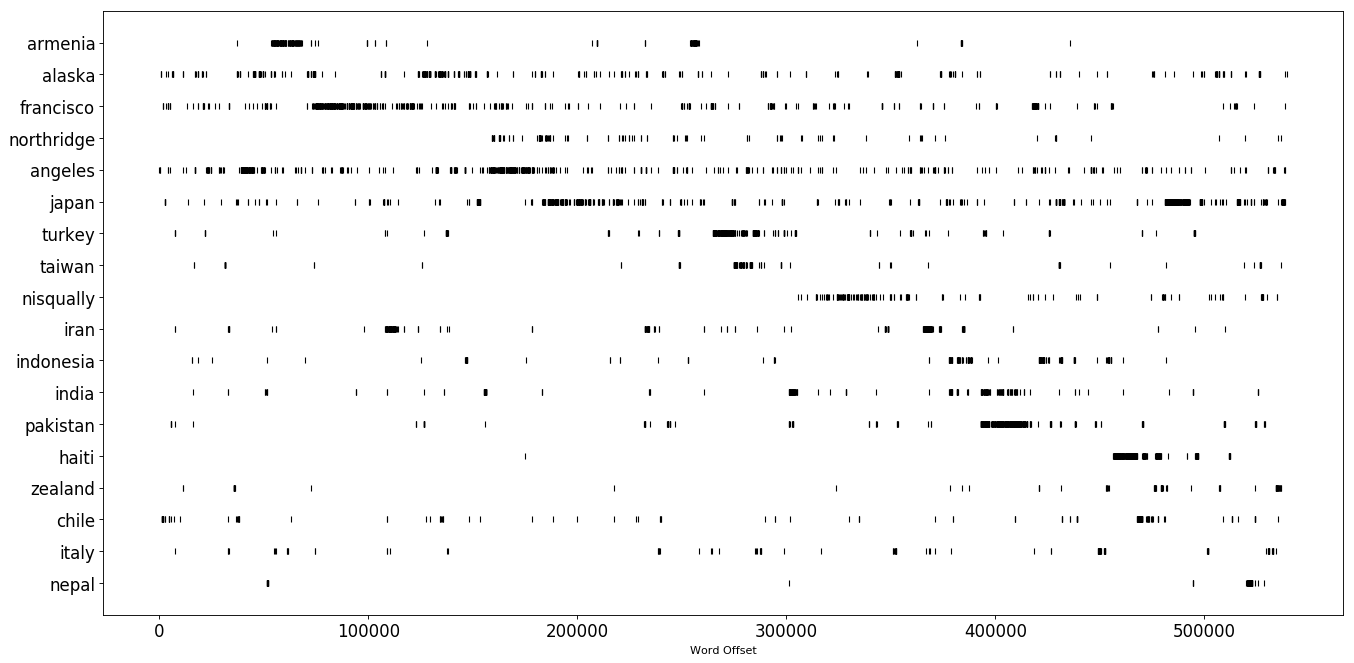

In [22]:
dispersion_words = ['francisco', 'taiwan', 'northridge', 'sumatra', 'christchurch', 'japan', 'turkey', 'nisqually']

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k', )
dispersion_plot(all_words_clean_nltk,event_words, ignore_case=True,
                         title='')

In [159]:
def dispersion_timeline(series, comp_words, title="Lexical Dispersion Plot", scale = 10, count_labels=False, period = 'A'):
    comp_words.reverse()

    series_gp = series['words'].groupby(pd.TimeGrouper(period)).sum()
    series_gp = series_gp[series_gp != 0]


    points = [(index, y, row.count(comp_words[y])) for index, row in series_gp.iteritems() 
                                                                      for y in range(len(comp_words))]
    
    dates, word_locs, counts = list(zip(*points))
    
    
    
    
    df_plot = pd.DataFrame({
        'dates': dates,
        'word_locs': word_locs,
        'area': [scale*i**2 * math.pi for i in counts]
                    })

    scat = plt.scatter(dates, word_locs, s=[scale*i**2 * math.pi for i in counts], c='b')
    scat.set_alpha(0.25)

#     plt.figure(facecolor="w", edgecolor='k')
    fig = plt.gcf()
    plt.style.use('seaborn-dark-palette')
    plt.rcParams['axes.facecolor'] = 'w'
    plt.rcParams['axes.edgecolor'] = 'k'
    fig.set_size_inches(30, 17)
#     plt.rcParams['axes.labelsize'] = '20'
    plt.tick_params(axis='both', labelsize=30, colors='k')
    plt.yticks(list(range(len(comp_words))), comp_words, color="k")
    plt.xticks([datetime(1980,1,1), datetime(1985,1,1), datetime(1990,1,1), datetime(1995,1,1), datetime(2000,1,1), datetime(2005,1,1),
               datetime(2010,1,1), datetime(2015,1,1), datetime(2020,1,1)])
    plt.ylim(-1, len(comp_words))
    plt.xlim(datetime(1980,1,1), datetime(2020,1,1))
    plt.grid(which='major', axis='both')
    plt.title(title, fontsize='30')
    plt.xlabel("", fontsize='40')

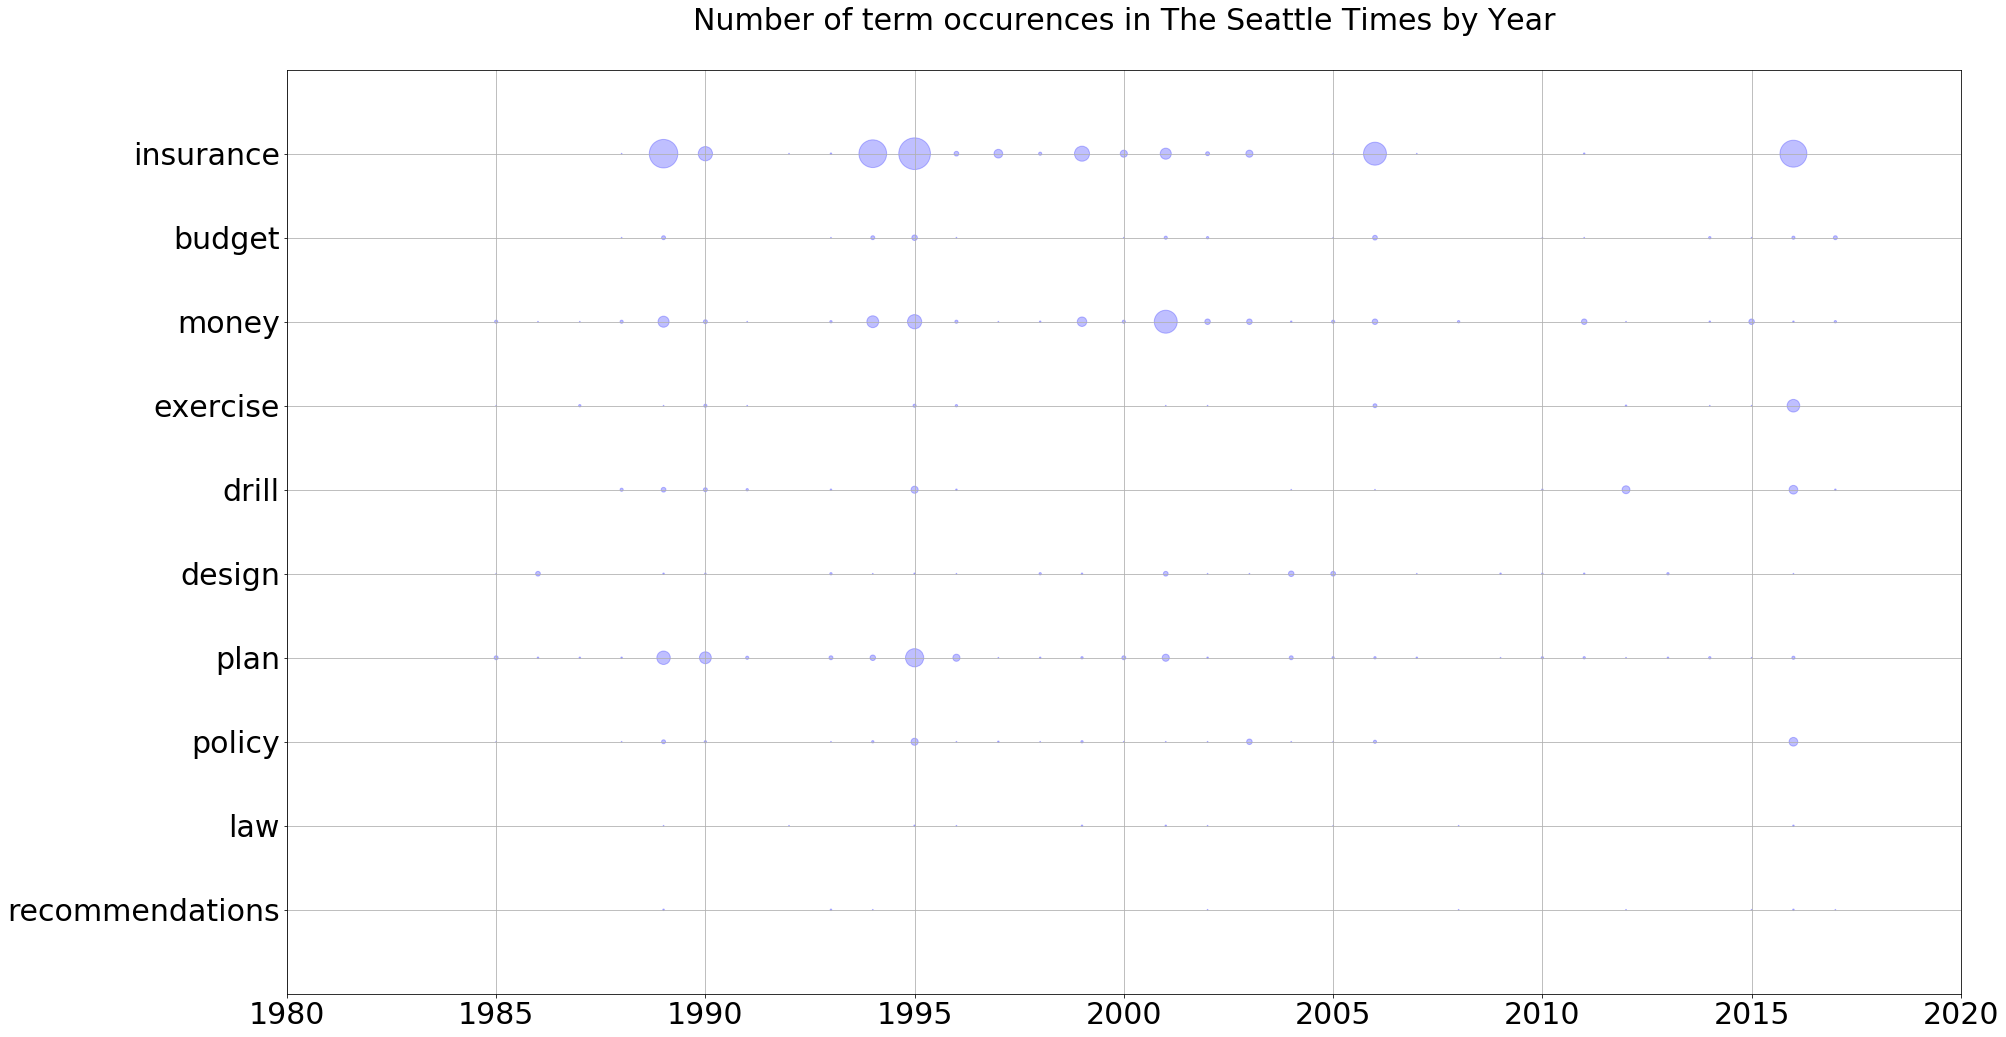

In [167]:
# dispersion_words = ['recovery', 'mitigation', 'prepare']


dispersion_timeline(series=df_local[['date', 'words']].set_index('date'), 
                    comp_words=action_words, title='Number of term occurences in The Seattle Times by Year\n', 
                    scale=.2, count_labels=True, period='AS')

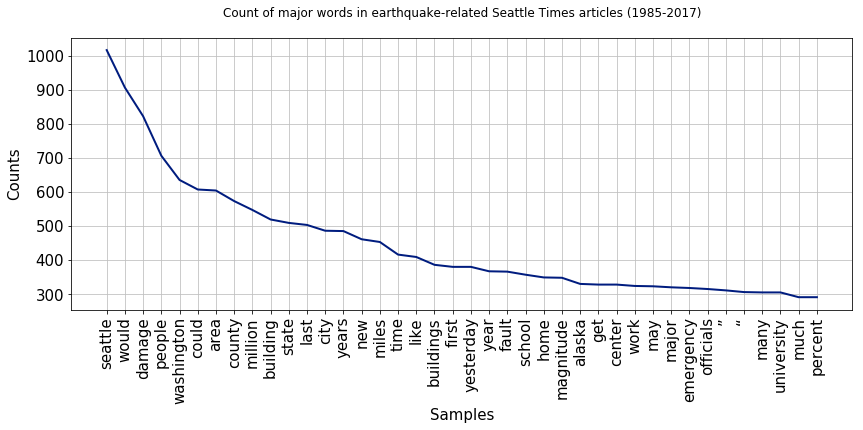

In [171]:
fd = nltk.FreqDist(all_words_clean_local)

plt.rcParams['axes.labelsize'] = '15'
plt.tick_params(axis='both', labelsize=15)
fig = plt.gcf()
plt.style.use('seaborn-dark-palette')
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['axes.labelsize'] = '20'
# plt.tick_params(axis='both', labelsize=30, colors='k')
# plt.title(fontsize='30')
plt.xlabel("", fontsize='15')
plt.ylabel("Word count", fontsize='15')
fig.set_size_inches(14, 5)
ax = plt.gca()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

fd.plot(40,cumulative=False, title='Count of major words in earthquake-related Seattle Times articles (1985-2017)\n')

In [178]:
title_words = [token.lower() for token in df_local['title'].tolist()]
title_words_clean_str = ' '.join(title_words).replace('quake', '').replace('earthquake','').replace('quakes', '')
title_words_clean_str = title_words_clean_str.replace('earthquakes','').replace('seismic', '').replace('earth', '')
title_words_clean_str = title_words_clean_str.replace('area','').replace('new', '').replace('may', '')
title_words_clean_str = title_words_clean_str.replace('one','').replace('year', '').replace('close', '')
title_words_clean_str = title_words_clean_str.replace('still','').replace('say', '').replace('day', '')
title_words_clean_str = title_words_clean_str.replace('test','').replace('digest', '').replace('will', '')
title_words_clean_str = title_words_clean_str.replace('site','').replace('set', '').replace('now', '')
title_words_clean_str = title_words_clean_str.replace('two','').replace('indsia', '').replace('make', '')

In [179]:
wc_factory = WordCloud(background_color="white", width=1200, height=600, min_font_size=12, prefer_horizontal=1.0,
                       font_step=25, margin=2, scale=10, max_words = 100, collocations=True, random_state=1)

wc = wc_factory.generate(title_words_clean_str)

(-0.5, 11999.5, 5999.5, -0.5)

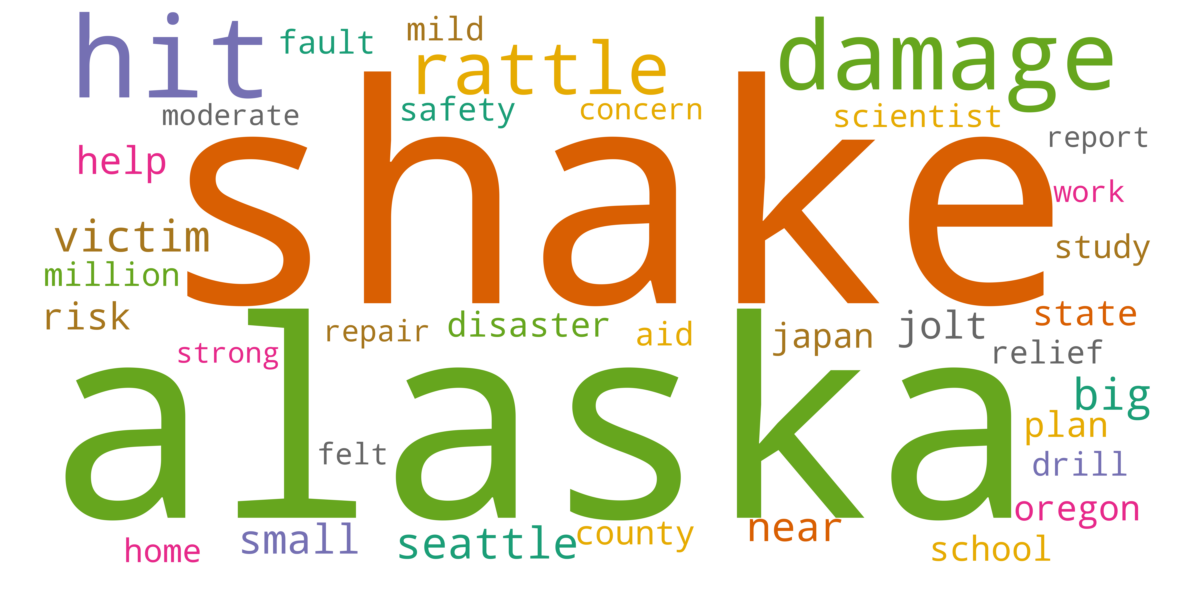

In [180]:
plt.imshow(wc.recolor(colormap=plt.cm.Dark2, random_state=3),
           interpolation="bilinear")
fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.axis("off")

In [187]:
df_years = df[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('AS')).sum()
df_years = df_years[df_years['clean words'] != 0]
df_years['clean word count'] = df_years['clean words'].apply(len)
df_years['articles count'] = df[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('AS')).size()

df_years_local = df_local[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('AS')).sum()
df_years_local = df_years_local[df_years_local['clean words'] != 0]
df_years_local['clean word count'] = df_years_local['clean words'].apply(len)
df_years_local['articles count'] = df_local[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('AS')).size()

df_years_nonlocal = df_nonlocal[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('AS')).sum()
df_years_nonlocal = df_years_nonlocal[df_years_nonlocal['clean words'] != 0]
df_years_nonlocal['clean word count'] = df_years_nonlocal['clean words'].apply(len)
df_years_nonlocal['articles count'] = df_nonlocal[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('AS')).size()

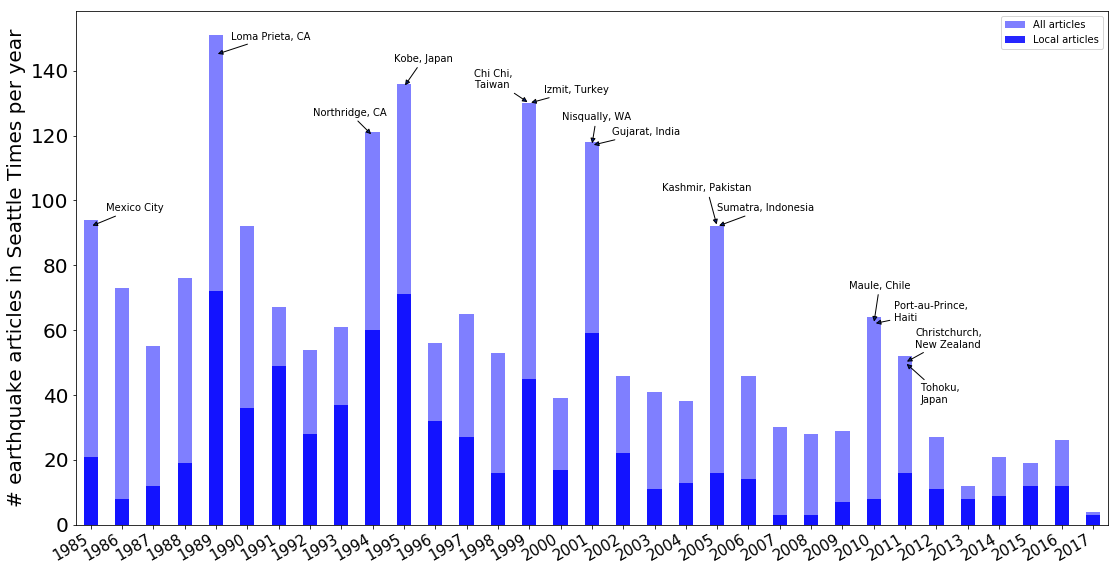

In [201]:
# fig, ax = plt.subplots()
ax = df_years.plot.bar(y='articles count', width=.45, legend = True, color='b', alpha = 0.5, label = 'All articles')
df_years_local.plot.bar(y='articles count', width=.45, legend = True, color='b', alpha = 0.85, ax = ax, label = 'Local articles')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.autofmt_xdate()
# ax = plt.gca()

ax.annotate('Mexico City', xy=(0, 92), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Loma Prieta, CA', xy=(4, 145), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Northridge, CA', xy=(9, 120), xytext=(-60, 20), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Kobe, Japan', xy=(10, 135), xytext=(-10, 25), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Izmit, Turkey', xy=(14, 130), xytext=(15, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Chi Chi,\nTaiwan', xy=(14, 130), xytext=(-55, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Gujarat, India', xy=(16, 117), xytext=(20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Nisqually, WA', xy=(16, 117), xytext=(-30, 25), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Sumatra, Indonesia', xy=(20, 92), xytext=(0, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Kashmir, Pakistan', xy=(20, 92), xytext=(-55, 35), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Port-au-Prince,\nHaiti', xy=(25, 62), xytext=(20, 3), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Maule, Chile', xy=(25, 62), xytext=(-25, 35), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Christchurch,\nNew Zealand', xy=(26, 50), xytext=(10, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
ax.annotate('Tohoku,\nJapan', xy=(26, 50), xytext=(15, -40), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

ax.xaxis_date()
ax.xaxis.set_major_formatter(plt.FixedFormatter(df_years.index.to_series().dt.strftime("%Y")))
plt.rcParams['axes.labelsize'] = '20'
plt.tick_params(axis='x', labelsize='15', colors='k')
plt.tick_params(axis='y', labelsize='20', colors='k')
# plt.title('Annual number of articles in The Seattle Times mentioning "quake", "earthquake", or "seismic"\n', fontsize='20')
plt.xlabel("Year")
plt.ylabel("# earthquake articles in Seattle Times per year", fontsize='20')
plt.xlabel("", fontsize='30')

In [31]:
# concord_word = 'insurance' # word to find concordances for
# concord_lines = 30 # number of output lines/concordances
# concord_context = 100 # number of characters extracted from left and right of concord_word

# filename = 'SeattleTimesQuakeArticles/outputs/temp_concord.txt'
# # Open the file
# filecolloc = open(filename, 'w')

# with redirect_stdout(filecolloc):
#     collocs = []
#     for i in range(len(df)):
#         collocs.append(df['nltk text'][i].concordance(concord_word, concord_context, concord_lines))

In [32]:
# filename = 'SeattleTimesQuakeArticles/outputs/collocs_all_clean_words_100.txt'

# filecolloc = open(filename, 'w')

# with redirect_stdout(filecolloc):
#     all_words_clean_nltk.collocations(num=50, window_size = 2)


In [33]:
output = io.StringIO()

with io.StringIO() as output, redirect_stdout(output):
    all_words_clean_nltk.common_contexts(words=['murray'], num=20)

    contents = output.getvalue()

contents = contents.replace(' ', '; ').replace('_', ' & ')
contents

'patty & d-wash.; mentioning & name; 7 & 3; fighting & plans; bob & though; read & back\n2001 & acquitted; monday & energy; jim & los; robert & cleveland; workers & ohio\ncriticized & company; never & style; 16 & 4; robert & president; ohio & chose\nminers & denials; outraged & call; company & energy; collapse & 67\n'

In [41]:
output2 = io.StringIO()

with io.StringIO() as output2, redirect_stdout(output2):
    all_words_clean_nltk.concordance('murray', width = 100, lines=50)

    contents2 = output2.getvalue()

print(contents2)

Displaying 39 of 39 matches:
springs colo. gazette telegraph commentary jim murray los angeles times criticism allan temko san fr
ork thick white mist rolled shea stadium eddie murray hit first home run new york ninth inning lift 
ilized move tents medicine equipment new delhi murray culshaw director british-based relief organiza
ges fg .437 ft .786 three-point goals 1-7 .143 murray 1-2 gatling 0-1 person 0-4 team rebounds 13 bl
d shots 4 weatherspoon 3 harpring turnovers 16 murray 4 coles 4 harpring 2 miller 2 traylor 2 jackso
 2 miller 2 traylor 2 jackson gatling steals 7 murray 3 weatherspoon 3 mihm technical fouls illegal 
government officials including u.s. sen. patty murray d-wash. credited program helping minimize dama
minimize damages last week 'm shocked outraged murray call cnn program ground pacific northwest last
r mine complying agreed-upon procedures robert murray president chief executive company operates min
activity rest produced tectonic-plate activity murray right na

In [42]:
# filename = 'SeattleTimesQuakeArticles/outputs/context_strengthen.txt'

# filecolloc = open(filename, 'w')

# with redirect_stdout(filecolloc):
#     all_words_clean_nltk.common_contexts(words=['fema'], num=50)


In [43]:
# filename = 'SeattleTimesQuakeArticles/outputs/bigrams.txt'

# filecolloc = open(filename, 'w')

# with redirect_stdout(filecolloc):
#     bcf = BigramCollocationFinder.from_words(all_words_clean_nltk)
#     bcf.nbest(BigramAssocMeasures.likelihood_ratio, 50)

In [44]:
# filename = 'SeattleTimesQuakeArticles/outputs/trigrams.txt'

# filecolloc = open(filename, 'w')

# with redirect_stdout(filecolloc):
#     tcf = TrigramCollocationFinder.from_words(all_words_clean_nltk)
#     tcf.nbest(TrigramAssocMeasures.likelihood_ratio, 50)

In [45]:
dictionary = corpora.Dictionary(df['clean words'].tolist())
corpus = [dictionary.doc2bow(text) for text in df['clean words'].tolist()]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [46]:
num_topics = 30

In [47]:
si = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics, chunksize=250, onepass=False)

for i in range(0, num_topics):
    topics = si.show_topic(i, 15)
    
    terms = []
    for topic in topics:
        terms.append(topic[0])
    
    print("SI topic #" + str(i) + ": "+ ", ".join(terms))

SI topic #0: alaska, richter, scale, tsunami, damage, city, miles, people, magnitude, san, seattle, reported, buildings, mexico, fault
SI topic #1: alaska, palmer, richter, anchorage, scale, tsunami, warning, moderate, centered, center, miles, damage, adak, injuries, reports
SI topic #2: fault, pakistan, seattle, iran, county, alaska, relief, rescue, aid, survivors, insurance, scientists, washington, california, ”
SI topic #3: alaska, tsunami, palmer, mexico, anchorage, warning, ”, “, richter, scale, reported, san, pakistan, angeles, los
SI topic #4: “, ”, japan, insurance, tsunami, fault, island, tokyo, alaska, waves, coast, san, safeco, million, county
SI topic #5: pakistan, mexico, japan, kobe, city, kashmir, tokyo, county, tsunami, islamabad, pakistani, washington, relief, afghanistan, seismology
SI topic #6: ”, “, japan, kobe, mexico, tokyo, japanese, san, insurance, island, alaska, nuclear, plant, hokkaido, los
SI topic #7: ”, “, insurance, fault, safeco, pakistan, alaska, covera

In [48]:
lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics, update_every=1, chunksize=250, passes=3)

for i in range(0, num_topics):
    topics = lda.show_topic(i, 15)
    terms = []
    for topic in topics:
        terms.append(topic[0])
    print("LDA topic #" + str(i) + ": "+ ", ".join(terms))

LDA topic #0: residential, halt, villagers, monument, protected, speak, charitable, village, floated, tragedies, crushing, virginia, forest, hillside, beef
LDA topic #1: crowd, background, issues, grant, saint, courthouse, plumes, prayed, hazard, dome, lord, l, paul, requests, discuss
LDA topic #2: oklahoma, insurance, funding, budget, trump, zone, work, across, schools, network, pawnee, systems, insurers, underground, coverage
LDA topic #3: gordon, threw, report.caption, shortages, clogged, palmer, officers, tasks, kodiak, unleashed, revealed, guerrero, paying, accepted, medbery
LDA topic #4: production, turkey, experience, bus, editorial, monday, written, euros, rods, sister-in-law, notice, hard-hit, couple, processes, phones
LDA topic #5: volumes, post, essential, 2,200, gathered, greek, desperate, flight, sheets, toxic, begins, wrapped, two-story, newly, heights
LDA topic #6: drilling, brick, zealand, buy, meeting, millions, february, protect, alone, key, piles, michelle, solutions

In [49]:
df_years = df[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('A')).sum()
df_years = df_years[df_years['clean words'] != 0]
df_years['clean word count'] = df_years['clean words'].apply(len)
df_years['articles count'] = df[['date', 'clean words']].set_index('date').groupby(pd.TimeGrouper('A')).size()
# df_years

In [50]:
series=df[['date','words']].set_index('date')

series_gp = series['words'].groupby(pd.TimeGrouper('AS')).sum()
series_gp = series_gp[series_gp != 0]

In [51]:
# comp_words_dict = dict(
#     action_words = action_words,
#     phase_words_pos = phase_words_pos,
#     phase_words_neg = phase_words_neg,
#     impact_words = impact_words,
#     location_words = location_words,
#     thing_words = thing_words,
#     people_words = people_words,
#     scale_words = scale_words,
#     event_words = event_words
#     )

# concord_lines = 15 # number of output lines/concordances
# concord_context = 120 # number of characters extracted from left and right of concord_word

# for comp_words_dir, comp_words in comp_words_dict.items():

#     path = 'SeattleTimesQuakeArticles/outputs/concords/' + comp_words_dir + '/'
    
#     os.makedirs(os.path.dirname(path), exist_ok=True)

#     for index, row in series_gp.iteritems():
#         for y in range(len(comp_words)):

#             filename = path + comp_words[y] + str(index.year) + '.txt'
            
#             file = open(filename, 'w')
            
#             with redirect_stdout(file):

#                 nltk.Text(row).concordance(comp_words[y], concord_context, concord_lines)

In [52]:
comp_words_dir = 'event_words'
comp_words = eval(comp_words_dir)

In [40]:
# # test_words = ['mayor', 'governor', 'washington']

# path = 'SeattleTimesQuakeArticles/outputs/concords/' + comp_words_dir + '/'
# os.makedirs(os.path.dirname(path), exist_ok=True)

# for index, row in series_gp.iteritems():
#     for y in range(len(comp_words)):

#         filename = path + comp_words[y] + str(index.year) + '.txt'
#         file = open(filename, 'w')
        
#         with redirect_stdout(file):
#             nltk.Text(row).concordance(comp_words[y], concord_context, concord_lines)

In [53]:
comp_words_dict.keys()

dict_keys(['event_words', 'impact_words', 'action_words', 'location_words', 'thing_words', 'phase_words_pos', 'people_words', 'scale_words', 'phase_words_neg'])

In [54]:
comp_words_dir = 'event_words'
comp_words = eval(comp_words_dir)

comp_words.reverse()

# comp_words = ['mayor', 'governor', 'washington']

path = 'SeattleTimesQuakeArticles/outputs/concords/' + comp_words_dir + '/'

hover_text = []
years = []
for year, group in series_gp.iteritems():
    for y in range(len(comp_words)):

        filename = path + comp_words[y] + str(year.year) + '.txt'

        with open(filename, 'r') as f:
            file_text = f.readlines()
            file_text = ''.join(file_text).replace('\n','<br>')
            hover_text.append(file_text)
            years.append(year.year)

In [55]:
contents = contents.replace(' ', '; ').replace('_', ' & ')
contents

hover_collocs = []
for row in hover_text:
    
    output = io.StringIO()

    with io.StringIO() as output, redirect_stdout(output):
        nltk.Text(word_tokenize(row)).collocations()

        hover_collocs.append(output.getvalue())

In [56]:
scale = .01

points = [(index, y, row.count(comp_words[y])) for index, row in series_gp.iteritems()                                                                  
                                                  for y in range(len(comp_words))]


dates, word_locs, counts = list(zip(*points))
# 
df_plot = pd.DataFrame({
    'dates': dates,
    'word_locs': word_locs,
    'area': [scale*i**2 * math.pi for i in counts],
    'hover_text': hover_text
                })

In [57]:
trace0 = go.Scatter(
    x=df_plot['dates'],
    y=df_plot['word_locs'],
    mode='markers',
    marker=dict(
        size=df_plot['area'],
        sizemode='area',
    ),
    text=df_plot['hover_text'],
    hoverinfo = 'x + y + text'
)

xaxis = go.XAxis(
    title="Year",
    showgrid=True,
    showline=True,
    ticks="", 
    showticklabels=True,
    mirror=True,
    linewidth=2,
    showspikes = True

)

yaxis = go.YAxis(
    range=[-2, len(comp_words)+2],
    showgrid=True,
    showline=True,
    ticks="", 
    showticklabels=True,
    mirror=True,
    linewidth=2,
    ticktext=comp_words,
    tickvals=list(range(len(comp_words))),
    showspikes = True
    
)
layout = go.Layout(
    title="",
    yaxis=yaxis,
    xaxis=xaxis,
    hovermode="closest"
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename=comp_words_dir)

In [46]:
df_plot2 = df_plot.set_index('dates')

In [47]:
df_plot[df_plot["dates"].isin(pd.date_range("2017-01-01", "2017-12-31"))]

,area,dates,hover_text,word_locs
576,0.000000,2017-01-01,,0
577,0.000000,2017-01-01,No matches<br>,1
578,0.000000,2017-01-01,No matches<br>,2
579,0.000000,2017-01-01,No matches<br>,3
580,0.000000,2017-01-01,No matches<br>,4
581,0.000000,2017-01-01,No matches<br>,5
582,0.000000,2017-01-01,No matches<br>,6
583,0.000000,2017-01-01,No matches<br>,7
584,0.000000,2017-01-01,No matches<br>,8
585,0.000000,2017-01-01,No matches<br>,9


In [48]:
df_plot.loc[(df_plot["area"]==0) & (df_plot["hover_text"].tolist().count('matches') > 0)]

,area,dates,hover_text,word_locs
